# Глава 3 (Иванов Илья, группа 3530901/70203)

## Упражнение 3.1.
Run and listen to the examples in chap03.ipynb, which is in the repository for this book, and also available at http://tinyurl.com/thinkdsp03.

In the leakage example, try replacing the Hamming window with one of the other windows provided by NumPy, and see what effect they have on leakage. See http://docs.scipy.org/doc/numpy/reference/routines.window.html

chap03.ipynb был просмотрен и разобран

In [4]:
from __future__ import print_function, division

%matplotlib inline

import thinkdsp
import thinkplot
import numpy as np

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
import math

Если длительность сигнала не кратна периоду, веротяно возникновение утечки спектра. Создадим подобный сигнал:

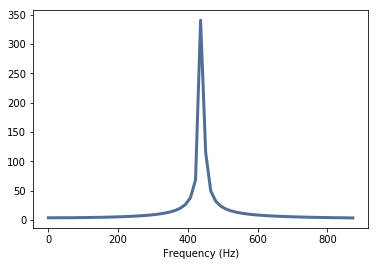

In [9]:
signal = thinkdsp.SinSignal(freq=440)
duration = signal.period * 30.25
wave = signal.make_wave(duration)
spectrum = wave.make_spectrum()

spectrum.plot(high=880)
thinkplot.config(xlabel='Frequency (Hz)')

В данном случае сигнал начинается с 0, а закнчивается на 1, что приводит к утечке спектра, видной на графике

Применим окно Блэкмана

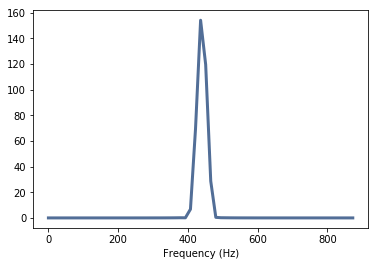

In [10]:
thinkplot.preplot(4)
wave.ys *= np.blackman(len(wave.ys))
spectrum = wave.make_spectrum()
spectrum.plot(high=880)
thinkplot.config(xlabel='Frequency (Hz)')

Утечки сократились заметно, хотя и не полностью

## Упражнение 3.2.
Write a class called SawtoothChirp that extends Chirp and overrides evaluate to generate a sawtooth waveform with frequency that increases (or decreases) linearly.

Hint: combine the evaluate functions from Chirp and SawtoothSignal.

Draw a sketch of what you think the spectrogram of this signal looks like, and then plot it. The effect of aliasing should be visually apparent, and if you listen carefully, you can hear it.

Класс, описывающий пилообразный сигнал с изменяющейся частотой:

In [14]:
class SawtoothChirp(thinkdsp.Chirp):
    
    def _evaluate(self, ts, freqs):
        dts = np.diff(ts)
        dps = 2 * math.pi * freqs * dts
        phases = np.cumsum(dps)
        phases = np.insert(phases, 0, 0)
        cycles = phases / ( 2 * math.pi)
        frac, _ = np.modf(cycles)
        ys = thinkdsp.normalize(thinkdsp.unbias(frac), self.amp)
        return ys

`ts`- последовательность моментов времени
`freqs` - последовательность частот на интервалах

Создадим `SawtoothChirp` и прослушаем его:

In [15]:
signal_swc = SawtoothChirp(start=220, end=880)
wave_swc = signal_swc.make_wave(duration=1, framerate=10000)
wave_swc.apodize()
wave_swc.make_audio()

Получим спектрограмму сигнала:

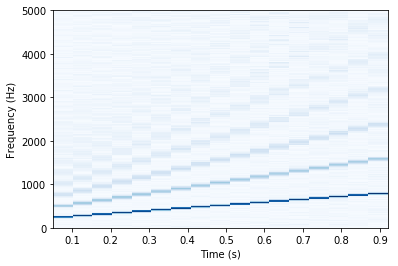

In [16]:
sp_swc = wave_swc.make_spectrogram(1024)
sp_swc.plot()
thinkplot.config(xlabel='Time (s)', ylabel='Frequency (Hz)')

Видно, что частота растёт линейно относительно времени

## Упражнение 3.3.
Make a sawtooth chirp that sweeps from 2500 to 3000 Hz, then use it to make a wave with duration 1 s and framerate 20 kHz. Draw a sketch of what you think the spectrum will look like. Then plot the spectrum and see if you got it right.

Базовая частота колеблется от 2500 до 3000 Гц. В этом диапазоне, вероятно, будет что-то похожее на Око Саурона. Первая гармоника находится в диапазоне от 5000 до 6000 Гц. В этом диапазоне тоже, вероятно, будет нечто похожее на Око Саурона, только немного пониже. Ну и аналогично со второй гармоникой, которая колеблется от 7500 до 9000 Гц. Кроме того, из-за явления алиасинга на всех остальных частотах также будет некоторая энергия.

Создадим сигнал, прослушаем его и получим его спектр:

In [19]:
signal_swc2 = SawtoothChirp(start=2500, end=3000)
wave_swc2 = signal_swc2.make_wave(duration=1, framerate=20000)
wave.make_audio()

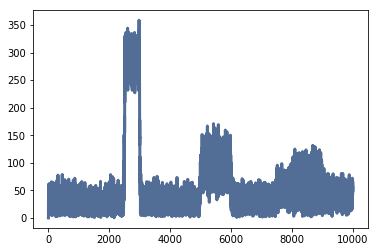

In [20]:
wave_swc2.make_spectrum().plot()

Ожидания оправдались, и на диапазонах 2500-3000 Гц, 5000-6000 Гц и 7500-9000 Гц  действительно можно увидеть столпы, а на остальных частотах какое-то кол-во энергии.

## Упражнение 3.4.
In musical terminology, a “glissando” is a note that slides from one pitch to another, so it is similar to a chirp.

Find or make a recording of a glissando and plot a spectrogram of the first few seconds. One suggestion: George Gershwin’s Rhapsody in Blue starts with a famous clarinet glissando, which you can download from http://archive.org/details/rhapblue11924

Скачаем запись глиссандо с freesound.org (https://freesound.org/people/rockwehrmann/sounds/72474/), воспроизведём её и получим спектрограмму:

In [24]:
wave_gliss = thinkdsp.read_wave('gliss.wav')
wave_gliss.make_audio()

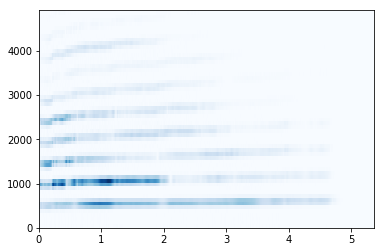

In [25]:
wave_gliss.make_spectrogram(512).plot(high=5000)

Полученная спектрограмма действительно напоминает спектрограмму пинообразного чирпа.

## Упражнение 3.5.
A trombone player can play a glissando by extending the trombone slide while blowing continuously. As the slide extends, the total length of the tube gets longer, and the resulting pitch is inversely proportional to length.

Assuming that the player moves the slide at a constant speed, how does frequency vary with time?

Write a class called TromboneGliss that extends Chirp and provides evaluate. Make a wave that simulates a trombone glissando from C3 up to F3 and back down to C3. C3 is 262 Hz; F3 is 349 Hz.

Plot a spectrogram of the resulting wave. Is a trombone glissando more like a linear or exponential chirp?


Класс, описывающий тромбоноподобный сигнал с переменной частотой:

In [41]:
class TromboneGliss(thinkdsp.Chirp):
    
    def evaluate(self, ts):
        l1, l2 = 1.0 / self.start, 1.0 / self.end
        lengths = np.linspace(l1, l2, len(ts)-1)
        freqs = 1 / lengths
        return self._evaluate(ts, freqs)

Создадим часть сигнала с уменьшающейся частотой:

In [42]:
signal_part1 = TromboneGliss(349, 262)
wave_part1 = signal_part1.make_wave(duration=1)
wave_part1.apodize()
wave_part1.make_audio()

А также с увеличивающейся частотой:

In [43]:
signal_part2 = TromboneGliss(262, 349)
wave_part2 = signal_part2.make_wave(duration=1)
wave_part2.apodize()
wave_part2.make_audio()

Склеим полученные части:

In [44]:
wave_tgliss = wave_part1 | wave_part2
wave_tgliss.make_audio()

Получим спектрограмму:

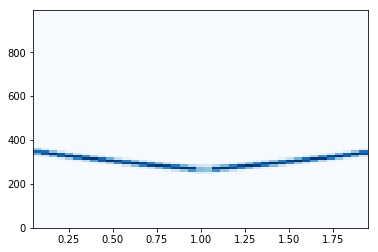

In [45]:
sp_tgliss = wave_tgliss.make_spectrogram(1024)
sp_tgliss.plot(high=1000)

Судя по спектрограмме, глиссандо на тромбоне весьма похоже на линейный чирп

## Упражнение 3.6.
Make or find a recording of a series of vowel sounds and look at the spectrogram. Can you identify different vowels?